In [1]:
from datetime import datetime
import warnings
import os
from collections import Counter

import pandas
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_percentage_error as mape
import numpy as np
import pymc as pm
import arviz as az

from get_model_training_data_05 import get_features_and_data
from get_model_training_data_05 import weighted_absolute_percentage_error as wape

%matplotlib inline
%config InlineBackend.figure_format = "retina"

sns.set(rc={"figure.figsize" : (25, 15)})
sns.set(font_scale=2)
sns.set_style("ticks")

warnings.filterwarnings("ignore")
os.environ["PYTHONWARNINGS"] = "ignore"

## Load Training and Testing Data

In [2]:
(df, train_df, test_df, feature_names, next_month) = get_features_and_data()

training examples = 2286, testing examples = 255


In [3]:
df["prob_of_release"] = df["prob_of_release"].apply(lambda x : 0.9999 if x == 1 else x)
train_df["prob_of_release"] = train_df["prob_of_release"].apply(lambda x : 0.9999 if x == 1 else x)
test_df["prob_of_release"] = test_df["prob_of_release"].apply(lambda x : 0.9999 if x == 1 else x)

## Model-Building and Evaluation

In [4]:
with pm.Model() as model:
    # data
    features = pm.MutableData("features", train_df[feature_names].T)
    # priors
    weights = pm.Normal("weights", mu=0, sigma=1, shape=len(feature_names))
    beta0 = pm.Normal("beta0", mu=0, sigma=1)
    error = pm.HalfNormal("error", sigma=0.5)
    # linear model
    mu = beta0 + pm.math.dot(weights, features)
    p = pm.Deterministic("p", pm.math.invlogit(mu))
    # likelihood
    # pm.Beta("y_pred", alpha=p, beta=(1 - p), shape=features.shape[1], observed=train_df["prob_of_release"])
    pm.TruncatedNormal("y_pred", mu=p, sigma=error, observed=train_df["prob_of_release"], lower=0, upper=1, shape=features.shape[1])

In [5]:
with model:
    idata = pm.sample(1000, tune=1000, chains=4, random_seed=1024)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [weights, beta0, error]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 68 seconds.


### Out-of-Sample Evaluation

In [6]:
with model:
    pm.set_data({"features" : test_df[feature_names].T})
    pred_test = pm.sample_posterior_predictive(idata, predictions=True, var_names=["y_pred"])

Sampling: [y_pred]


In [7]:
y_pred = np.mean(pred_test.predictions["y_pred"].stack(all_draws=["chain", "draw"]).values, axis=1)

In [8]:
mape(test_df["prob_of_release"], y_pred)

0.27142521663173386

In [9]:
wape(test_df["prob_of_release"], y_pred)

0.23099790989962113

## Predictions for the Next Month

In [10]:
with pm.Model() as model:
    # data
    features = pm.MutableData("features", df[feature_names].T)
    # priors
    weights = pm.Normal("weights", mu=0, sigma=1, shape=len(feature_names))
    beta0 = pm.Normal("beta0", mu=0, sigma=1)
    error = pm.HalfNormal("error", sigma=0.5)
    # linear model
    mu = beta0 + pm.math.dot(weights, features)
    p = pm.Deterministic("p", pm.math.invlogit(mu))
    # likelihood
    pm.TruncatedNormal("y_pred", mu=p, sigma=error, observed=df["prob_of_release"], lower=0, upper=1, shape=features.shape[1])

In [11]:
with model:
    idata = pm.sample(1000, tune=1000, chains=4, random_seed=1024)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [weights, beta0, error]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 67 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details


In [12]:
with model:
    pm.set_data({"features" : next_month[feature_names].T})
    pred_next = pm.sample_posterior_predictive(idata, predictions=True, var_names=["y_pred"])

Sampling: [y_pred]


In [13]:
next_month["predicted_prob"] = np.mean(pred_next.predictions["y_pred"].stack(all_draws=["chain", "draw"]).values, axis=1)

In [14]:
hdi = pm.hdi(pred_next.predictions["y_pred"], hdi_prob=0.95)
next_month["predicted_min"] = hdi["y_pred"][:, 0]
next_month["predicted_max"] = hdi["y_pred"][:, 1]

In [15]:
next_month[["index", "predicted_min", "predicted_prob", "predicted_max"]].round(4)

,index,predicted_min,predicted_prob,predicted_max
1,2024-02-03,0.0000,0.1901,0.4551
2,2024-02-04,0.0006,0.3093,0.6393
3,2024-02-05,0.0005,0.4124,0.7603
4,2024-02-06,0.1745,0.5616,0.9581
5,2024-02-07,0.3479,0.6838,0.9998
6,2024-02-08,0.4365,0.7518,0.9999
7,2024-02-09,0.4932,0.7805,0.9998
8,2024-02-10,0.5035,0.7919,1.0000
9,2024-02-11,0.5428,0.8053,0.9999
10,2024-02-12,0.5573,0.8159,0.9999


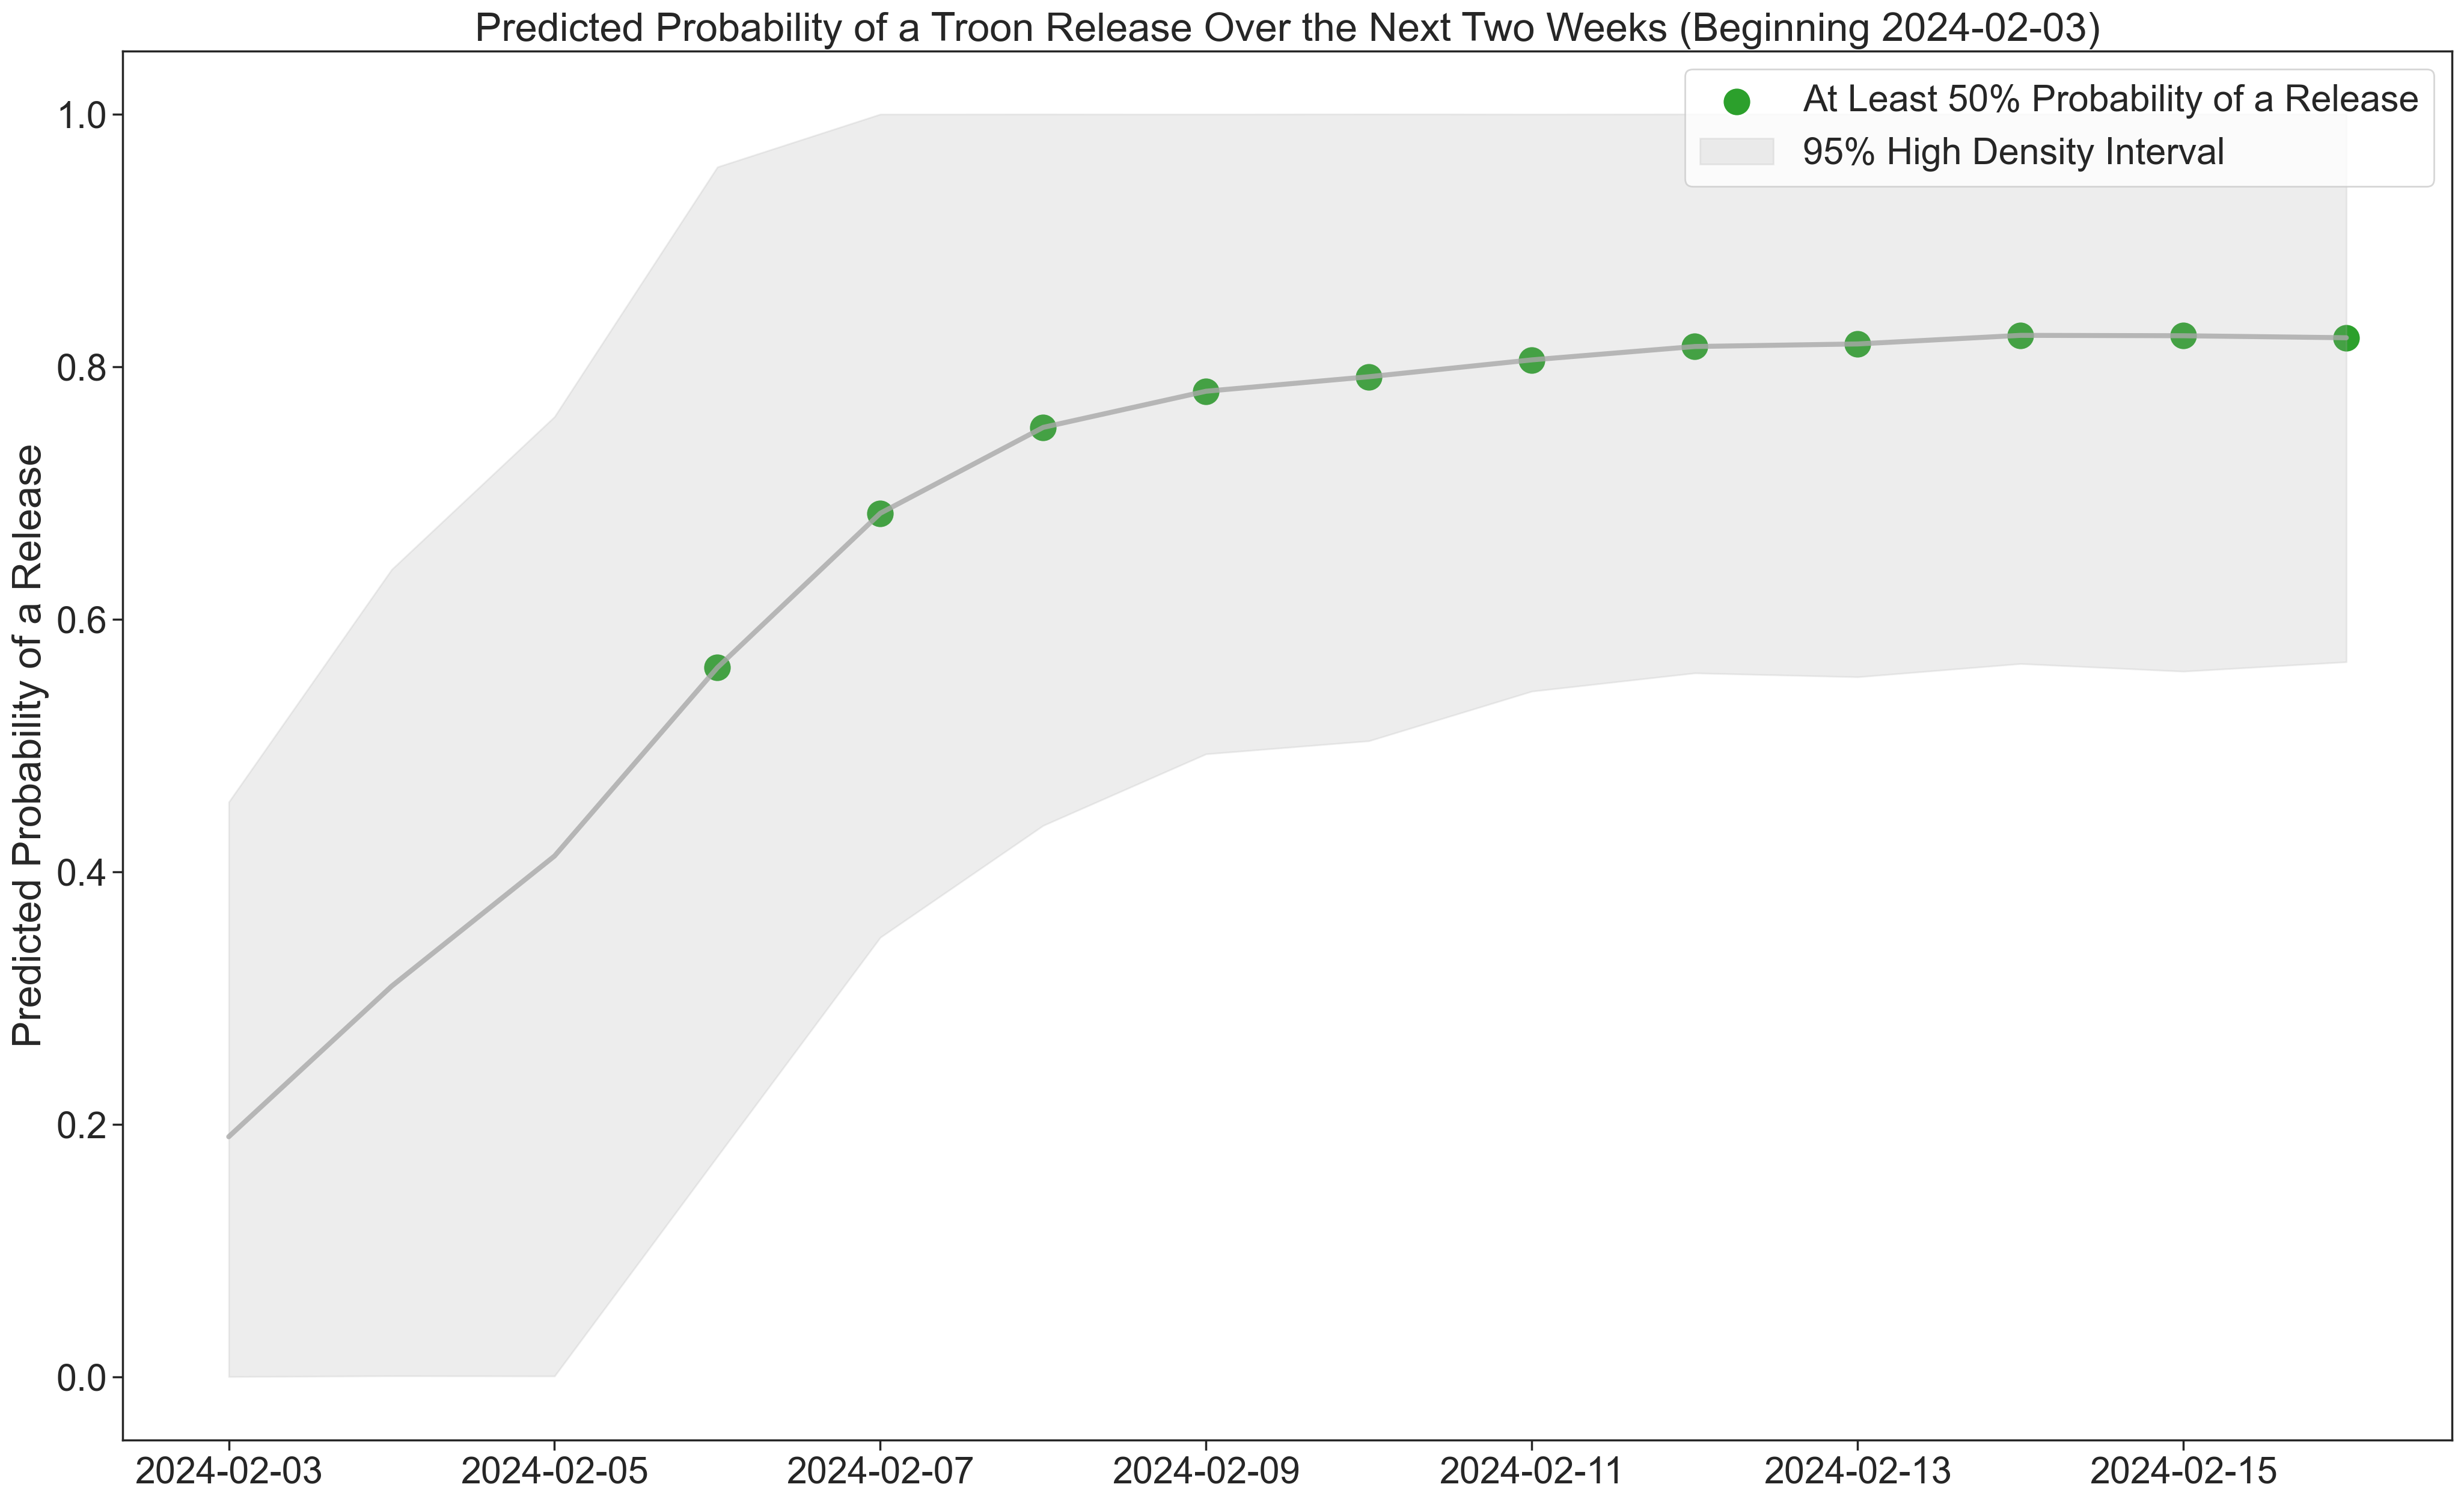

In [16]:
ax = sns.lineplot(data=next_month[:14], x="index", y="predicted_prob", linewidth=3, color="darkgrey", alpha=0.8)
sns.scatterplot(data=next_month[:14][next_month["predicted_prob"] >= 0.50], x="index", y="predicted_prob",
                s=300, ax=ax, color="tab:green", label="At Least 50% Probability of a Release")

ax.fill_between(x=next_month[:14]["index"],
                y1=next_month[:14]["predicted_min"],
                y2=next_month[:14]["predicted_max"],
                label="95% High Density Interval",
                alpha=0.2,
                color="darkgrey")

ax.set_xlabel(None)
ax.set_ylabel("Predicted Probability of a Release")
ax.set_title("Predicted Probability of a Troon Release Over the Next Two Weeks (Beginning {})".format(
    next_month["index"].iloc[0].date()))
ax.legend()
plt.show()